In [1]:
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from tqdm import tqdm, trange #顯示當前執行進度
from speedup import Kmeans

In [ ]:
def initialization():
    global k_number,k_cycle,image_path,output_path,compare
    #kmean中心點數量，執行幾次後收斂，影像輸入路徑，影像輸出路徑，比較有無重複取值得開關,進度條起始點
    k_number ,k_cycle,image_path,output_path,compare=3,3,'D:\\ncku.jpg',"D:\\output.jpg",True

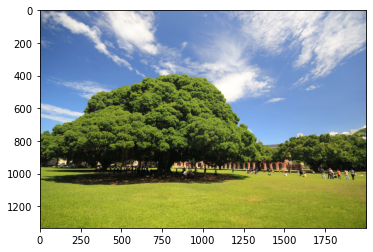

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]

----
[0.7450980392156863, 0.6509803921568628, 0.5176470588235295]
[0.8196078431372549, 0.8313725490196079, 0.8588235294117647]
----
[0.7450980392156863, 0.6509803921568628, 0.5176470588235295]
[0.4, 0.5882352941176471, 0.8470588235294118]
----
[0.8196078431372549, 0.8313725490196079, 0.8588235294117647]
[0.7450980392156863, 0.6509803921568628, 0.5176470588235295]
----
[0.8196078431372549, 0.8313725490196079, 0.8588235294117647]
[0.4, 0.5882352941176471, 0.8470588235294118]
----
[0.4, 0.5882352941176471, 0.8470588235294118]
[0.7450980392156863, 0.6509803921568628, 0.5176470588235295]
----
[0.4, 0.5882352941176471, 0.8470588235294118]
[0.8196078431372549, 0.8313725490196079, 0.8588235294117647]


In [12]:
#初始化
initialization()
# 讀取圖案轉array，二維矩陣
img=Image.open(image_path)
img_array = (np.array(img)/255.0)
data = img_array.reshape(img_array.shape[0]*img_array.shape[1],3)
#手肘法，將seed與群內點做計算，將每一群的結果相加，最後的總合除以k值就為距離
#距離來劃出手肘點，第二的明顯的轉折點為最佳
# K = range(1,10)
# elbow_plt = []
# for k in K:
#     model = Kmeans(k)
#     new_img, distortion = model.fit(data)
#     elbow_plt.append(distortion/k)
# plt.plot(K,elbow_plt,"b*-")
# plt.show()
# plt.savefig('D:\\elb.jpg')

# img_array = (np.array(img)/255.0)
Height,Weidth,Channel=img_array.shape
#製造空白矩陣，後面要做運算
# blank_martix= np.ndarray(img_array.shape[0:2], dtype=np.int32)
#test
blank_martix=np.zeros(shape=(Height,Weidth), dtype=np.int32)
#顯示輸入圖片
plt.imshow(img)
plt.show()

#比較取的RGB是否有重複。直到取到都不重複為止
while compare:
    #將二維陣列 轉 一維陣列
    one_dimensional_array=img_array.reshape(Height * Weidth,Channel)
    arr_number,array_channel=one_dimensional_array.shape
    #從矩陣中隨機抽取RGB數值
    #先取k_numer個數值，再從一維陣列中找這幾個位置的RGB數值
    sampling_seed=one_dimensional_array[np.random.choice(arr_number,size=k_number,replace=False)]
    #過濾RGB點數
    for i in tqdm(range(len(sampling_seed))):
        #轉list處理
        sampling_seed_list=sampling_seed.tolist()
        for j in range(len(sampling_seed)):
            temp_1=sampling_seed_list[i]
            #去除跟自己比
            if i!=j:   
                temp_2=sampling_seed_list[j]
                compare==False
                compare=np.array_equiv(temp_1, temp_2)
                print("----")
                print(temp_1)
                print(temp_2)


In [14]:
#定義影像上的某pixel跟seed中心點計算距離
def distance(x, y):
    return np.dot(x - y, x - y) ** (1 / 2)

def calculate_nearest_seed(Height,Weidth,k_number,img_array):
    for i in range(Height):
        for j in range(Weidth):
            shortest_distance = float('inf')
            min_blank_martix = None
            for cluster in range(k_number):
                #算跟每個seed的距離，image_point為影像中的pixel，sampling_seed為seed
                #影像矩陣的pixel
                image_pixel=img_array[i][j]
                #算影像矩陣的pixel & seed 之間的距離
                pixel_distance = distance(image_pixel, sampling_seed[cluster])
                # 找到一個點跟每個seed最短的
                if pixel_distance < shortest_distance:
                    min_blank_martix = cluster
                    shortest_distance = pixel_distance
            #將數值塞回空白矩陣
            blank_martix[i,j] = min_blank_martix
    return blank_martix
#計算群中的平均
def calculate_average(k_number,Channel,Height,Weidth,blank_martix,img_array):
    for cluster in range(k_number):
        #群內有幾筆
        cluster_collect = 0
        #
        cluster_sum = np.ndarray(Channel)
        for i in range(Height):
            for j in range(Weidth):
                if blank_martix[i,j] == cluster:
                    cluster_collect=cluster_collect+1
                    image_pixel=img_array[i][j]
                    cluster_sum =cluster_sum+image_pixel
        if cluster_collect > 0:
            #做平均
            sampling_seed[cluster] = cluster_sum / cluster_collect
    return sampling_seed
#在裡面算距離，將最短的歸類成這個點  
for round in tqdm(range(k_cycle)):
    #算圖與中心點距離(影像矩陣高,影像矩陣寬,k值,影像矩陣)
    blank_martix=calculate_nearest_seed(Height,Weidth,k_number,img_array)
    # 計算群中的平均(k值,通道數,影像矩陣高,影像矩陣寬,影像童大小空白矩陣,影像矩陣)
    sampling_seed=calculate_average(k_number,Channel,Height,Weidth,blank_martix,img_array)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:14<00:00, 24.72s/it]


In [11]:
#把對映數值放到MAP上，轉圖片
blank_martix_map = np.ndarray(img_array.shape)
for i in range(Height):
    for j in range(Weidth):
        #指定到類別上
        blank_martix_map[i,j] = sampling_seed[blank_martix[i,j]]

np.clip(blank_martix_map, 0, 1)
blank_martix_map *= 255
blank_martix_img = Image.fromarray(blank_martix_map.astype(np.uint8)) # Convert to PIL format
#將array轉成圖片
# result_img=Image.fromarray(blank_martix_img.astype(np.uint8),'L')
print('Save image to ' + output_path)
blank_martix_img.save(output_path)

Save image to D:\output.jpg
